In [1]:
import pandas as pd
import numpy as np
from os import listdir, chdir, system
from os.path import isfile, join, getmtime, split
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 200
from skimage.registration import phase_cross_correlation
from scipy.ndimage import correlate1d
import shutil

Script used to work on fixing the dataset some more after the project is due

In [2]:
#Utility Functions

def EI_data_from_snapshot(filename,header = 22,kinetic_to_binding=False):
    """This function gets the data from from a dictionary of linesthe kinetic energy, counts line data in the spectra"""
    f = open(filename)
    linedata = f.readlines()
    f.close()
    dataset = np.zeros((len(linedata[header:]),2))
    for i, row in enumerate(linedata[header:]):
        if "#" not in row:
            row_split = row.split()
            dataset[i,0] = np.float64(row_split[0])
            dataset[i,1] = np.float64(row_split[-1])  
    if kinetic_to_binding:
        dataset[:,0] = 1486.7-dataset[:,0]
    return dataset


def get_metadata(filename):
    """This function just gets the transition"""
    f = open(filename)
    lines = f.readlines()
    f.close()
    line1 = lines[0].split(" ")     #get the xps transition type from the metadata
    transition = line1[-2]+ line1[-1]
    transition = transition.replace("\n","")
    stepline = lines[6].split(" ")
    step = np.float64(stepline[-1].replace("\n",""))
    return transition, step


def plot_all_spectra(dataframe):
    for i, row in dataframe.iterrows():
        data = row["data"]
        e = data[:,0]
        i = data[:,1]
        plt.plot(e, i)


def normalize_to_one(spectra):
    """
    Takes a spectra (energy, intensity in a two column array) and normalizes the max to 1 and min to zero
    :param spectra:
    :return: normalized
    """
    normed_spectra = np.zeros(spectra.shape)
    normed_spectra[:,0] = spectra[:,0]
    spectra_max = np.max(spectra[:, 1])
    spectra_min = np.min(spectra[:, 1])
    normed_spectra[:, 1] = (spectra[:, 1] - spectra_min) / (spectra_max - spectra_min)
    return normed_spectra


def copy_all_files(dataframe):
    for j, folder in enumerate(dataframe["Folder Path"]):
        folderpath = folder

        files = [f for f in listdir(folderpath) if (isfile(join(folderpath, f)) and ("DS_Store" and "copy" and "shifted" and ".csv") not in f)]
        files = [join(folderpath, f) for f in files] # add path to each file
        print(files)
        
        for i, file in enumerate(files):
            filename = split(file)
            destination = '/Users/apple/Sync/Classwork/Materials Informatics/Final Project/Dataset/XPS Data/'+filename[1]
            shutil.copy(file, destination)


def make_common_range(dataframe):
    """finds the common range between spectra of a certain transition in a dataframe"""
    startindex = dataframe.first_valid_index()
    startdata = dataframe.loc[startindex,"data"]
    min = np.amin(startdata[:,0])
    max = np.amax(startdata[:,0])

    for i, row in dataframe.iterrows():
        data = row["data"]
        current_min = np.amin(data[:,0])
        current_max = np.amax(data[:,0])
        if current_min > min:
            min = current_min
        if current_max < max:
            max = current_max
    print(min, max)
    common_indices = np.argwhere((data[:,0]>min) & (data[:,0]<max))
    formatted_data_array = np.zeros((len(dataframe),len(common_indices)))
    j = 0
    
    for i, row in dataframe.iterrows():
        data = row["data"]
        common_indices = np.argwhere((data[:,0]>min) & (data[:,0]<max))
        common_data = data[common_indices,1]
        formatted_data_array[j,:] = np.reshape(common_data, len(common_indices))
        j+=1
    dataframe = dataframe.reset_index(drop=True)
    columnlabels = np.round(np.reshape(data[common_indices,0],len(common_indices)),2)
    formatted_dataframe = pd.concat([dataframe, pd.DataFrame.from_records(formatted_data_array,columns=columnlabels)],axis=1)

    return formatted_dataframe

def spectra_interpolate(xy, step = 0.05, bounds=False):
    """Given an input array of x, y values, this will interpolate the data using scipy's cubic interpolation
    to get a function with the interpolated data and desired boundaries and step"""
    if bounds==False:
        bounds = (np.min(xy[:,0],np.max(xy[:,0])))
    inputshape = xy.shape
    if inputshape[1] != 2 and inputshape[0] == 2:
        xy = np.transpose(xy)
        print("linear_interpolate() transposed the x,y data")

    f = interp1d(xy[:,0], xy[:,1], kind='cubic')
    xnew = np.arange(bounds[0], bounds[1]+step, step)
    ynew = f(xnew)
    xnew = np.array(xnew)
    ynew = np.array(ynew)
    interpolated = np.stack((xnew,ynew))

    return np.transpose(interpolated)

In [3]:
#Functions with dependency
def get_folder_scans(dataframe: pd.DataFrame):

    masterlist = pd.DataFrame(columns= dataframe.columns)
    
    for j, folder in enumerate(dataframe["Folder Path"]):
        folderpath = folder
        foldersum = 0

        files = [f for f in listdir(folderpath) if (isfile(join(folderpath, f)) and ("DS_Store" and "copy" and "shifted" and ".csv") not in f)]
        files = [join(folderpath, f) for f in files] # add path to each file
        print(files)
        
        for i, file in enumerate(files):

            data = EI_data_from_snapshot(file,kinetic_to_binding=True)
            data = normalize_to_one(data)
            transition,step = get_metadata(file)
            
            series = dataframe.loc[j].to_dict()
            file_dictionary = {'Filepath': file,
                               'Transition': transition,
                               'Step' : step,
                                'data': data
                                }
            joined_entry = {**series, **file_dictionary}
            
            masterlist = masterlist.append([joined_entry])
    return masterlist.reset_index()

def align_spectra(input_dataframe,reference, debug=False, normalize = False, max_shift = 10):
    """Reads a dataframe with the format output by the function find_snapshots_in_dir() and aligns them using the phase_cross_correlation() method from the skimage package
    the step size of the scans being aligned needs to be the same as this is a rigid translation
    The dataframe should contain a column called 'data' where the data is a [scanlength,2] np array of energy, intensity colums"""

    shifted_data = pd.DataFrame(columns= input_dataframe.columns)
    
    for index, row in input_dataframe.iterrows():
        step = row['Step']
        target = row['data']
        if normalize:
            shifted = normalize_to_one(target)
        else:
            shifted = target.copy()

        correlation = correlate1d(target[:,1], reference, mode='constant',cval=0.0)
        int_shift = int(len(reference)/2-np.argmax(correlation))
        # shift, error, diffphase = phase_cross_correlation(reference, target)
        # int_shift = (int(shift[0]))
        if debug:
            print(int_shift)
        if abs(int_shift) < max_shift:
            print(int_shift)
            shifted[:,0] = shifted[:,0]+-step*int_shift
        else:
            int_shift = 0.0
        plt.plot(shifted[:,0],shifted[:,1])

        series = input_dataframe.loc[index].to_dict()
        file_dictionary = {'shifted': shifted,
                            'shift': int_shift*step,
                            }
        joined_entry = {**series, **file_dictionary}
        shifted_data = shifted_data.append([joined_entry])
    return shifted_data

In [4]:
stepped_folder_directory = pd.read_csv("stepped heating directories.csv")
stepped_folder_directory = stepped_folder_directory.drop(["Unnamed: 9"],axis=1)
stepped_heating_data = get_folder_scans(stepped_folder_directory)

['/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--1_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--3_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--5_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--7_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--2_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--4_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/10-13-23 Ni22Cr Native Oxide/20231013-151606_Ni22Cr--ESp_Cayman_iXPS--6_1-Detector_Region.txt']
['/Us

<ipython-input-2-c251d9d048e1>:50: RuntimeWarning: invalid value encountered in true_divide
  normed_spectra[:, 1] = (spectra[:, 1] - spectra_min) / (spectra_max - spectra_min)


['/Users/apple/Sync/Research/Native Oxide work/Anna ambient oxide NiCr work/exported Ni15Cr air-oxide anneal/650 C/+ 37.5 deg rot/shifted_copy_20210429-095612_--ESp_Cayman_iXPS--32_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/Anna ambient oxide NiCr work/exported Ni15Cr air-oxide anneal/650 C/+ 37.5 deg rot/20210429-095612_--ESp_Cayman_iXPS--27_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/Anna ambient oxide NiCr work/exported Ni15Cr air-oxide anneal/650 C/+ 37.5 deg rot/20210429-095612_--ESp_Cayman_iXPS--31_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/Anna ambient oxide NiCr work/exported Ni15Cr air-oxide anneal/650 C/+ 37.5 deg rot/copy_20210429-095612_--ESp_Cayman_iXPS--29_1-Detector_Region.txt', '/Users/apple/Sync/Research/Native Oxide work/Anna ambient oxide NiCr work/exported Ni15Cr air-oxide anneal/650 C/+ 37.5 deg rot/shifted_copy_20210429-095612_--ESp_Cayman_iXPS--30_1-Detector_Region.txt', '/Users/apple

528.01 535.97


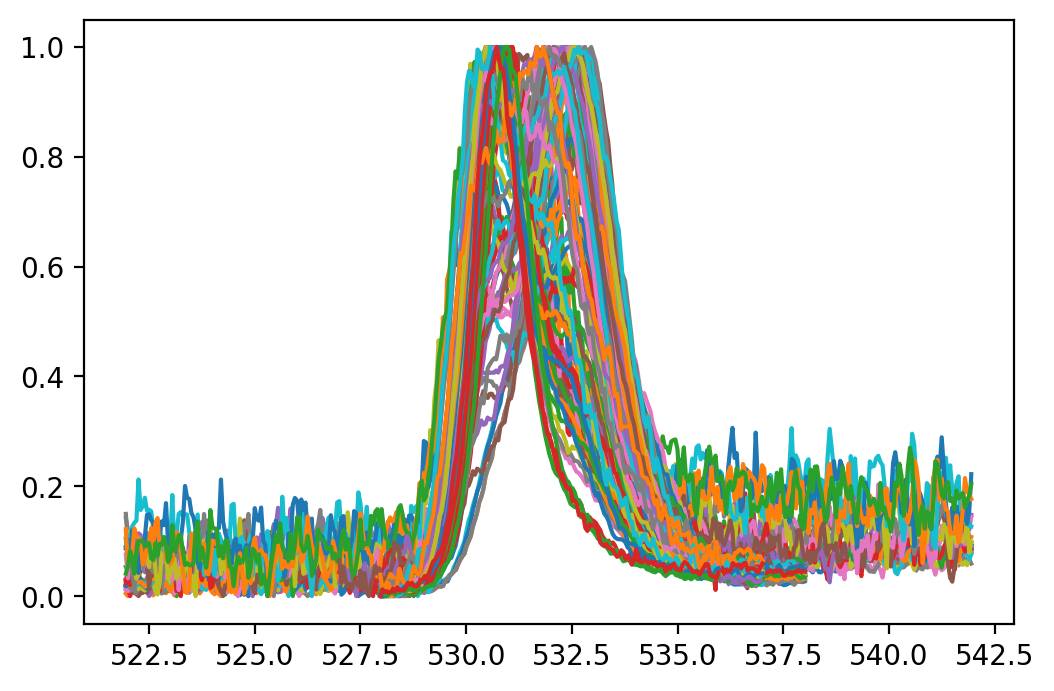

In [396]:
#load and align the oxygen spectra

o_subset = stepped_heating_data[stepped_heating_data.Transition == "O1s"]
o_subset = o_subset[o_subset.Step == 0.05]
plot_all_spectra(o_subset)
formatted_o_dataframe = make_common_range(o_subset)
#print(formatted_o_dataframe.head())
formatted_o_dataframe = formatted_o_dataframe.drop(["data"],axis=1)
formatted_o_dataframe.to_csv("o_data.csv")


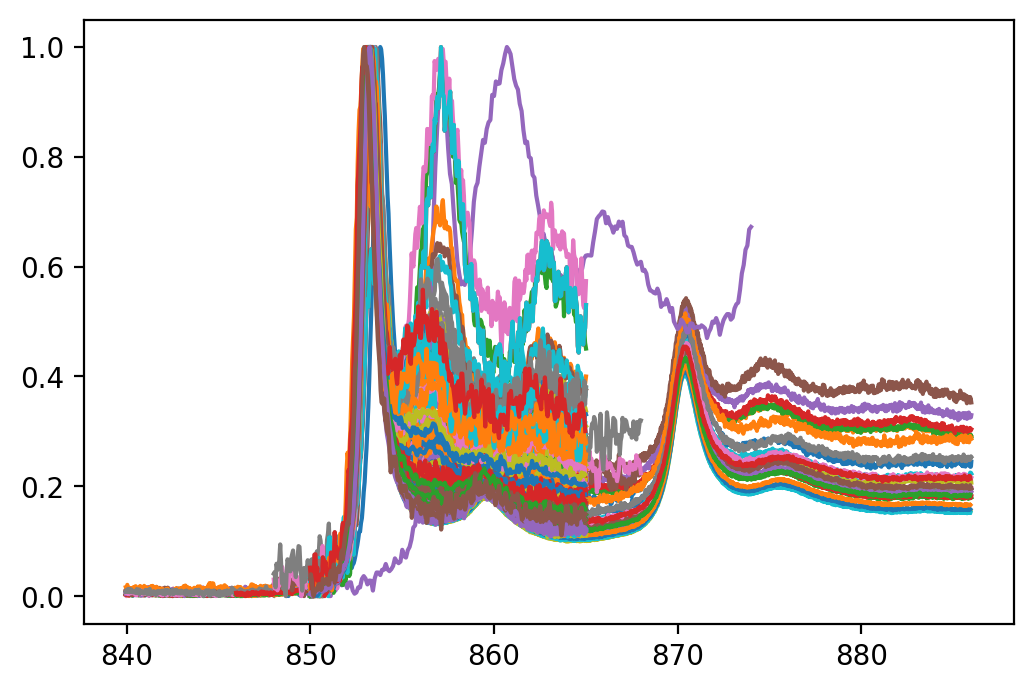

In [397]:
#load and align the Ni spectra

ni_subset = stepped_heating_data[stepped_heating_data.Transition == "Ni2p3/2"]
plot_all_spectra(ni_subset)
ni_subset = ni_subset[ni_subset.Step ==0.05]
reference = ni_subset.loc[1514,'data']
reference = reference[:,1]

#ni_aligned = align_spectra(ni_subset,reference,normalize=True, max_shift=40)

In [398]:
#load and align the Ni spectra

formatted_ni_dataframe = make_common_range(ni_subset)
print(formatted_ni_dataframe.head())
formatted_ni_dataframe = make_common_range(ni_subset)
formatted_ni_dataframe = formatted_ni_dataframe.drop(["data"],axis=1)
formatted_ni_dataframe.to_csv("ni_data.csv")


850.01 864.97
   index                Experiment      Date  Manipulator Angle Temperature  \
0      0       ni22cr native oxide  10/23/23                0.0          23   
1      0    Ni22Cr6Mo native oxide   9/21/23              -27.5          23   
2      0    Ni22Cr6Mo native oxide   9/21/23                0.0          23   
3      0    Ni22Cr6Mo native oxide   9/21/23               27.5          23   
4      0  Ni22Cr Fast Hold aqueous  10/21/21               35.0          23   

     Cr    Ni    Mo    W                                        Folder Path  \
0  0.22  0.78  0.00  0.0  /Users/apple/Sync/Research/Native Oxide work/1...   
1  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
2  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
3  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
4  0.22  0.78  0.00  0.0  /Users/apple/Sync/Research/Muri NiCr experimen...   

   ...    850.47    850.42    850.37

In [399]:
#load and make and align/make a common range for the Cr spectra

cr_subset = stepped_heating_data[stepped_heating_data.Transition == "Cr2p3/2"]
cr_subset = cr_subset[cr_subset.Step == 0.05]

#plot_all_spectra(cr_subset)
reference = cr_subset.loc[1,"data"]
#plt.plot(reference[:,0],reference[:,1])
reference = reference[:,1]
cr_subset.head()

,index,Experiment,Date,Manipulator Angle,Temperature,Cr,Ni,Mo,W,Folder Path,Filepath,Transition,Step,data
1,0,ni22cr native oxide,10/23/23,0.0,23,0.22,0.78,0.00,0.0,/Users/apple/Sync/Research/Native Oxide work/1...,/Users/apple/Sync/Research/Native Oxide work/1...,Cr2p3/2,0.05,"[[587.0, 0.7575773080281036], [586.95, 0.76340..."
454,0,Ni22Cr6Mo native oxide,9/21/23,-27.5,23,0.22,0.72,0.06,0.0,/Users/apple/Sync/Research/Native Oxide work/N...,/Users/apple/Sync/Research/Native Oxide work/N...,Cr2p3/2,0.05,"[[587.0, 0.6909228068877662], [586.95, 0.65789..."
461,0,Ni22Cr6Mo native oxide,9/21/23,0.0,23,0.22,0.72,0.06,0.0,/Users/apple/Sync/Research/Native Oxide work/N...,/Users/apple/Sync/Research/Native Oxide work/N...,Cr2p3/2,0.05,"[[587.0, 0.725407513984052], [586.95, 0.674250..."
465,0,Ni22Cr6Mo native oxide,9/21/23,27.5,23,0.22,0.72,0.06,0.0,/Users/apple/Sync/Research/Native Oxide work/N...,/Users/apple/Sync/Research/Native Oxide work/N...,Cr2p3/2,0.05,"[[587.0, 0.6241244785754927], [586.95, 0.66473..."
479,0,Ni22Cr Fast Hold aqueous,10/21/21,35.0,23,0.22,0.78,0.00,0.0,/Users/apple/Sync/Research/Muri NiCr experimen...,/Users/apple/Sync/Research/Muri NiCr experimen...,Cr2p3/2,0.05,"[[582.01, 0.3016562816322577], [581.96, 0.3149..."


In [ ]:
cr_aligned = align_spectra(cr_subset,reference,normalize=True, max_shift=20)

In [400]:
formatted_dataframe = make_common_range(cr_subset)
print(formatted_dataframe.head())
formatted_dataframe = formatted_dataframe.drop(["data"],axis=1)
formatted_dataframe.to_csv("cr_data.csv")


572.01 581.97
   index                Experiment      Date  Manipulator Angle Temperature  \
0      0       ni22cr native oxide  10/23/23                0.0          23   
1      0    Ni22Cr6Mo native oxide   9/21/23              -27.5          23   
2      0    Ni22Cr6Mo native oxide   9/21/23                0.0          23   
3      0    Ni22Cr6Mo native oxide   9/21/23               27.5          23   
4      0  Ni22Cr Fast Hold aqueous  10/21/21               35.0          23   

     Cr    Ni    Mo    W                                        Folder Path  \
0  0.22  0.78  0.00  0.0  /Users/apple/Sync/Research/Native Oxide work/1...   
1  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
2  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
3  0.22  0.72  0.06  0.0  /Users/apple/Sync/Research/Native Oxide work/N...   
4  0.22  0.78  0.00  0.0  /Users/apple/Sync/Research/Muri NiCr experimen...   

   ...    572.47    572.42    572.37